# Beauty Classifier


In [3]:
# !pip install wget

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Setup and Helpers

In [14]:
# Imports
%run ../src/utils/helpers.py

from collections import defaultdict
import requests
import boto3
import tempfile
import wget

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Initialization
s3_client = boto3.client('s3')
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
bucket_name = 'eye-of-the-needle'
bucket = s3.Bucket(bucket_name)

Records loaded. 500 out of 2392 photos have been labeled stunning.

Displaying images scored 0:
['2018/03/08/2018_0308_145000/thumbnail.jpg']


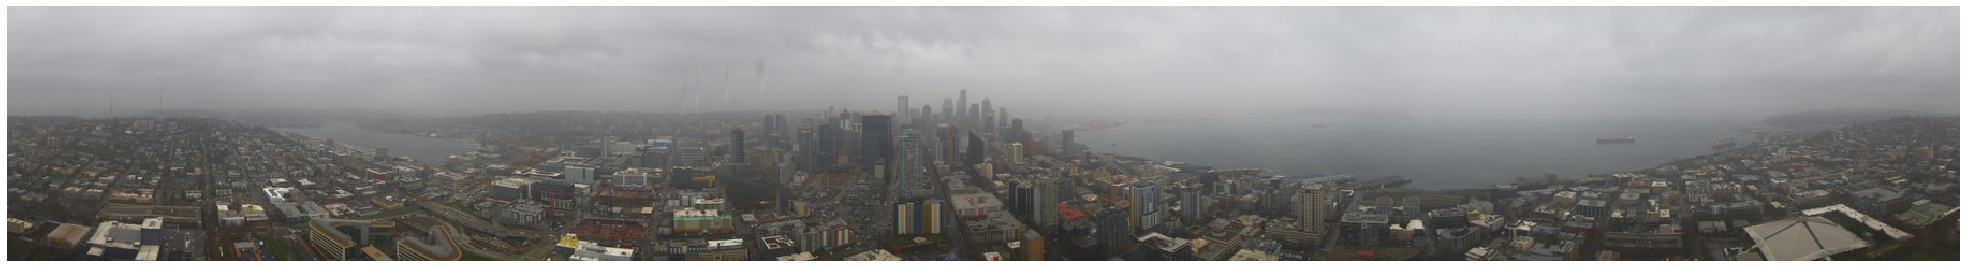

In [12]:
# Helper functions
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record


def display_images(n, score=1):
    record = get_record()
    scores = sum(v['score'] for k, v in record.items())
    print(f"Records loaded. {scores} out of {len(record.keys())} photos have been labeled stunning.")
    l = list(record.keys())

    n_files = []
    while len(n_files) < n:
        f = random.choice(l)
        if record[f]['score'] == score:
            n_files.append(f)

    print(f"\nDisplaying images scored {score}:")
    print(n_files)
    fig = plt.figure(figsize=(35, 12))
    for i, file in enumerate(n_files):
        obj = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            obj.download_fileobj(f)
            img=mpimg.imread(tmp.name)
        ax = fig.add_subplot(n, 1, i + 1) 
        ax.imshow(img)
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    return img
n = 1
img = display_images(n, 0)

In [7]:
from IPython.display import Image

fn = '../data/interim/_1130_4528215.png'
display(Image(filename=fn) )

FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/_1130_4528215.png'

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

pil_im = Image.open(fn) #Take jpg + png
## Uncomment to open from URL
#import requests
#r = requests.get('https://www.vegvesen.no/public/webkamera/kamera?id=131206')
#pil_im = Image.open(BytesIO(r.content))
im_array = np.asarray(pil_im)
plt.imshow(im_array)
plt.show()

OSError: cannot identify image file '../data/interim/_1130_4528215.png'

In [5]:
img.shape

(237, 1820, 3)

# Prep Data

In [7]:
import boto3
import os

from sklearn.model_selection import train_test_split


s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')

def download_from_s3(prefix, local_path, bucket=bucket_name, client=s3_client, resource=s3_resource):
    keys = []
    dirs = []
    next_token = ''
    base_kwargs = {
        'Bucket': bucket_name,
        'Prefix': prefix,
    }
    while next_token is not None:
        kwargs = base_kwargs.copy()
        if next_token != '':
            kwargs.update({'ContinuationToken': next_token})
        results = s3_client.list_objects_v2(**kwargs)
        contents = results.get('Contents')
        for i in contents:
            k = i.get('Key')
            if k[-1] != '/':
                keys.append(k)
            else:
                dirs.append(k)
        next_token = results.get('NextContinuationToken')
    for d in dirs:
        dest_pathname = os.path.join(local, d)
        if not os.path.exists(os.path.dirname(dest_pathname)):
            os.makedirs(os.path.dirname(dest_pathname))
    for k in keys:
        if not os.path.exists(os.path.dirname(local_path)):
            os.makedirs(os.path.dirname(local_path))
        resource.meta.client.download_file(bucket, k, local_path)
    return


def get_files(data, path):
    local_files = set(os.listdir("../data/imgs/"))
    target_files = set(data['filename'])
    missing = target_files.difference(local_files)
    needed = data[data['filename'].isin(missing)]
    print(f'Getting {len(missing)} files from S3...')
    needed.apply(lambda x: download_from_s3(x['filepath'], path + x['filename']), axis=1)
    print('Success!\n')
    pass


def get_df_from_record():
    record = get_record()
    df = pd.DataFrame.from_dict(record, orient='index').reset_index().sort_values(by='index')
    save_to(df, '../data/raw/df.pkl')
    return df


def process_df(df):
    parse = lambda x: ''.join(x.split('/')[3].split('_'))[:-2]
    date_strings = df['index'].apply(parse)
    filenames = date_strings + 'thumb.jpg'
    df['filename'] = filenames

    df['date'] = pd.to_datetime(date_strings, format='%Y%m%d%H%M', errors='ignore')
    df = df.set_index(pd.DatetimeIndex(df['date'])).drop('date', axis=1)
    df = df.rename(columns={'index': 'filepath'})
    save_to(df, '../data/interim/data.pkl')
    
    df['target'] = df.apply(lambda x: ['fine', 'beautiful'][x['score']], axis=1)
    return df


def run():
    path = '../data/imgs/'
    if 'imgs' not in os.listdir('../data/'):
        os.mkdir('../data/imgs')
    
    df = get_df_from_record()
    data = process_df(df)
    
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.2, random_state=42)
    
    save_to(train, '../data/interim/train.pkl')
    save_to(val, '../data/interim/val.pkl')
    save_to(test, '../data/interim/test.pkl')
    
    proportion = lambda x: x['score'].sum() / x.shape[0]
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    get_files(data, path)
    
    return data

In [8]:
data = run()

Saved file to ../data/raw/df.pkl
Saved file to ../data/interim/data.pkl
Saved file to ../data/interim/train.pkl
Saved file to ../data/interim/val.pkl
Saved file to ../data/interim/test.pkl

Train set has 1530 images with 21.11% positive class.
Val set has 383 images with 21.41% positive class.
Test set has 479 images with 19.83% positive class.

Getting 0 files from S3...
Success!



In [13]:
len(data)

2392

In [116]:
from sklearn.model_selection import KFold
    
kf = KFold(n_splits=5, random_state=True) # Define the split - into 2 folds 
splits = kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator


## Extract features from convolutional base

We want to use a solution based on pre-trained models. We will use models that are composed of two parts:

* Convolutional base.
* Classifier.

Our approach will use the convolutional base to extract features, using them to train a classifier to classify the input image as beautiful or not. Therefore, the features extracted from the convolutional base will be the same for all classifiers studied in this example.

Now let's see how to extract features from a convolutional base.

In [15]:
# Imports
import os, shutil, sys

from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as k

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception


In [31]:
def extract_features(data, img_height, img_width, conv_base, batch_size=32):
    sample_count = data.shape[0]
    print(f'Samples: {sample_count}')
    
#     features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    features = np.zeros(shape=(sample_count, 8, 57, 2048))
    labels = np.zeros(shape=(sample_count))

    
    # Preprocess data
    datagen = ImageDataGenerator(rescale=1./255)    
    generator = datagen.flow_from_dataframe(dataframe=data, 
                                            directory='../data/imgs/', 
                                            x_col='filename', 
                                            y_col='target', 
                                            target_size=(img_height, img_width),
                                            class_mode='binary', 
                                            batch_size=batch_size,
                                            save_to_dir='../data/interim/int_imgs/'
                                           )

    
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features, labels


def get_data():
    train = load_from('../data/interim/train.pkl')
    val = load_from('../data/interim/val.pkl')
    test = load_from('../data/interim/test.pkl')

    proportion = lambda x: x['score'].sum() / x.shape[0]
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    return (train, val, test)


def get_model(model, img_height, img_width):
    if model == 'xception':
         conv_base = Xception(weights='imagenet', 
                              include_top=False, 
                              input_shape=(img_height, img_width, 3)) 
     
    elif model == 'inception':
        conv_vase = InceptionV3(weights='imagenet', 
                                include_top=False,
                                input_shape=(img_height, img_width, 3))
    
    elif model == 'vgg':
        conv_base = VGG16(weights='imagenet', 
                          include_top=False,
                          input_shape=(img_width, img_height, 3))
        
    display(conv_base.summary())
    return conv_base


def train_and_predict():
    img_height, img_width = (237, 1820)
    conv_base = get_model('xception', img_height, img_width)
    train, val, test = get_data()
    data = {'train': {'data': train}, 'val': {'data': val}, 'test': {'data': test}}
    for k, v in data.items():
        print(f'Extracting features from {k} dataset')
        v['features'], v['labels'] = extract_features(v['data'], img_height, img_width, conv_base)

    return data


def run():
    results = train_and_predict()
#     save_to(results, '../models/output/results.pkl')
    return results

    

In [30]:
def get_datagen(data, set_name):
    datagen = ImageDataGenerator(rescale=1. / 255)
    generator = datagen.flow_from_dataframe(dataframe=data,
                                            directory='../data/imgs/', 
                                            x_col='filename', 
                                            y_col='target', 
                                            target_size=(img_height, img_width),
                                            class_mode='binary', 
                                            batch_size=batch_size)
    return generator


def extract_features(img_height, img_width, conv_base, model_name, batch_size=32):
    # Params
    nb_epoch = 50
    base_model_last_block_layer_number = 126 # based on number of layers in base model
    
    # Top Model Block
    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)

    # add your top layer block to your base model
    model = Model(conv_base.input, predictions)
    print(model.summary())

    # Visualize layer names and layer indices to see how many layers/blocks to re-train
    # uncomment when choosing based_model_last_block_layer
    for i, layer in enumerate(model.layers):
        print(i, layer.name)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all layers of the based model that is already pre-trained.
    for layer in conv_base.layers:
        layer.trainable = False

    # Read data and get generators
    train, val, test = get_data()

    train_generator = get_datagen(train, 'train')
    val_generator = get_datagen(val, 'val')
    
    model.compile(optimizer='nadam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Save weights of best training epoch: monitor either val_loss or val_acc
    model_path = f'../models/{model_name}/'
    os.makedirs(model_path, exist_ok=True)
    top_weights_path = f'{model_path}top_model_weights.h5'
    callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_acc', patience=5, verbose=0)
    ]

    # Train Simple CNN
    model.fit_generator(train_generator,
                        samples_per_epoch=train_generator.nb_sample,
                        nb_epoch=nb_epoch / 5,
                        validation_data=validation_generator,
                        nb_val_samples=validation_generator.nb_sample,
                        callbacks=callbacks_list)
    
    # Verbose
    print("\nStarting to Fine Tune Model\n")

    # Add the best weights from the train top model
    # At this point we have the pre-train weights of the base model and the 
    # trained weight of the new/added top model
    # We re-load model weights to ensure the best epoch is selected and not the last one.
    model.load_weights(top_weights_path)

    # Base_model_last_block_layer_number points to the layer in your model you want to train.
    # For example if you want to train the last block of a 19 layer VGG16 model this should be 15
    # If you want to train the last Two blocks of an Inception model it should be 172
    # layers before this number will used the pre-trained weights, layers above and including this number
    # will be re-trained based on the new data.
    for layer in model.layers[:base_model_last_block_layer_number]:
        layer.trainable = False
    for layer in model.layers[base_model_last_block_layer_number:]:
        layer.trainable = True

    # Compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(optimizer='nadam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    # Save weights of best training epoch: monitor either val_loss or val_acc
    final_weights_path = f'{model_path}model_weights.h5'
    callbacks_list = [
        ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    ]

    # Fine-tune the model
    model.fit_generator(train_generator,
                        samples_per_epoch=train_generator.nb_sample,
                        nb_epoch=nb_epoch,
                        validation_data=validation_generator,
                        nb_val_samples=validation_generator.nb_sample,
                        callbacks=callbacks_list)
    
    # Save model
    model_json = model.to_json()
    with open(f'{model_path}model.json', 'w') as json_file:
        json_file.write(model_json)
    print(f'Model written to {model_path}model.json')
    return


def get_data():
    train = load_from('../data/interim/train.pkl')
    val = load_from('../data/interim/val.pkl')
    test = load_from('../data/interim/test.pkl')

    proportion = lambda x: x['score'].sum() / x.shape[0]
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    return (train, val, test)


def get_model(model_name, img_height, img_width):
    if model_name == 'xception':
        conv_base = Xception(weights='imagenet', 
                             include_top=False, 
                             input_shape=(img_height, img_width, 3))
     
    elif model_name == 'inception':
        conv_base = InceptionV3(weights='imagenet', 
                                include_top=False,
                                input_shape=(img_height, img_width, 3))
    
    elif model_name == 'vgg':
        conv_base = VGG16(weights='imagenet', 
                          include_top=False,
                          input_shape=(img_width, img_height, 3))
        
    display(conv_base.summary())
    return conv_base


def train_and_predict(model_name):
    img_height, img_width = (237, 1820)
    conv_base = get_model(model_name, img_height, img_width)
    extract_features(img_height, img_width, conv_base, model_name)

    return 


def run():
    model_name = 'xception'
    train_and_predict(model_name)
    k.clear_session()
    return 

    

In [32]:
results = run()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 237, 1820, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 118, 909, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 118, 909, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 118, 909, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

None

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 1530 images with 21.11% positive class.
Val set has 383 images with 21.41% positive class.
Test set has 479 images with 19.83% positive class.

Extracting features from train dataset
Samples: 1530
Found 1530 images belonging to 2 classes.
Extracting features from val dataset
Samples: 383
Found 383 images belonging to 2 classes.
Extracting features from test dataset
Samples: 479
Found 479 images belonging to 2 classes.


# Classifier

In [27]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.imagenet_utils import decode_predictions
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


In [ ]:
epochs = 100

if model == 'vgg':
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(8, 57, 2048)))
    model.add(layers.Dense(256, activation='relu', input_dim=(8 * 57* 2048)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    display(model.summary())
    
    # Compile model
    model.compile(optimizer=optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    # Train model
    history = model.fit(train_features, train_labels,
                        epochs=epochs,
                        batch_size=batch_size, 
                        validation_data=(validation_features, validation_labels))
    
    # Save model
    model.save('vgg16.h5')

if model == 'xception' or model == 'inception':
    base_model = InceptionV3(include_top=False, pooling='avg')
    for layer in base_model.layers:
        layer.trainable = False
    output = Dense(2, activation='softmax')(base_model.output)
    model = Model(base_model.input, output)
    


## From lecture

In [13]:

# note we exclude the final dense layers and add one back below, we would retrain it ourselves
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(237, 1820, 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(2, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

## Non-recommended method

In [6]:
# Download pre-trained weights
# print('Beginning file download of pre-trained weights')
# url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'  
# filepath = '../models/vgg16_weights.h5'
# wget.download(url, filepath)  

Beginning file download of pre-trained weights


'../models/vgg16_weights.h5'

In [25]:
import os
import wget

In [ ]:
weight_file = '../models/vgg16_weights.h5'

if not os.path.exists(weight_file):
    # Download pre-trained weights
    print('Beginning file download of pre-trained weights')
    url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'  
    filepath = '../models/vgg16_weights.h5'
    wget.download(url, filepath)  
#     raise FileNotFoundError("No file {weight_file} found. Check path again".format(weight_file))
